# This notebook goal is to **convert files exported from Google Earth Engine to Cocofile format**

This notebook do:

1. Import files from Drive exported from Gee:
    1. Mosaic in Tif format;
    2. Labels in Tif format;
    3. csv with labels instance colors (equals to labels image);
2. Apply a function to padronize csv file in Json;
3. Clone cocosynth repository from github;
4. Get the mosaics, labels and Json files and transform in cocofile format


## Save files in Google Earth Engine:
Script GEE JavaScript: 



<a target="_blank"  href="https://code.earthengine.google.com/?scriptPath=users%2Fagrosatelite_mapbiomas%2Fmapbiomas_tutorial%3Acollection7%2Firrigation%2Fpivot_dynamics%2F01_export_training_samples.js"> View Script on GEE</a></td></table>



**CAUTION**

The FeatureCollection used as reference map is a shapefile maded by ANA (Agência Nacional de Águas). The shapefile 'id' (rows) were converted to  'RGB_COMPOS' in attribute table in string format. These value are the RGB compose to instance segmentation used to train the model, as exemplified in image  below:

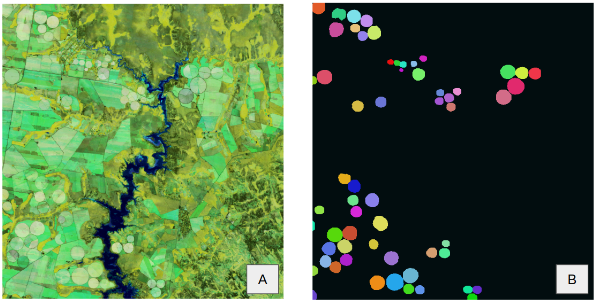



## Configure the notebook

### import libraries

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os, json, cv2, random
from google.colab.patches import cv2_imshow
import os
import sys
import glob 
from tqdm import tqdm

### Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## 1. Import files from Drive exported from Gee

In [ ]:
input_dir = '/content/drive/MyDrive/Colab Notebooks/Instance_Segmentation_center_pivot_irrigation/convert_Gee2Cocofile/MODEL_FILES'
# train dir
annotations_train = glob.glob(input_dir + '/annotations_train_')
image_dir_train = glob.glob(input_dir + '/images_train_')
mask_dir_train = glob.glob(input_dir + '/masks_train_')

# test dir
annotations_test = glob.glob(input_dir + '/annotations_test_')
image_dir_test = glob.glob(input_dir + '/images_test_')
mask_dir_test = glob.glob(input_dir + '/masks_test_')

Create a json file with these informations:
<code>

    {
    "info":{
        "description": "Pivo dataset",
        "version": "1",
        "url": "no-url/datasets.com",
        "year": 2022,
        "contributor": "Remap",
        "date_created": "22/01/2022"
        },
    "license":{
        "url":"no-url/licenses.com",
        "id": 0,
        "name": "pivot_train"
        }
    }

</code>

and save in 'annotations' folders (one in 'annotations_train_' and other in 'annotations_test_')

## 2. Apply a function to padronize csv file in Json

In [ ]:
# image_dir
# mask_dir
# annotations

def Get_Masks_definitions(dir_image,dir_mask,dir_anntotations):

    """The parsing function.
        Create a dictionary combine mosaic, labels and annotations files.
        Args:
            dir_image: directory stored the mosaics
            dir_mask: directory stored the labels
            dir_anntotations: directory stored the annotations files
        Returns:
            A dictionary in cocosynth format.
    """
  
    final_dict = {
          "masks":{
              
          },
          
          "super_categories":{
              "pivot":[
                "pivot"
              ]
          }
        }

    mask_dict = {}

    for path in dir_image:
      imgs = [f for f in glob.glob(path + "/*mosaic.tif", recursive=True)]
     

      if len(imgs) == 0:
            print("No samples found.")
      
      with tqdm(total=len(imgs)) as pbar:
      
        for image_path in imgs:
          pbar.update(1)
          mosaic_name = image_path          
          file_name = image_path.split('/')[-1].split('.')[0]
          
          labels_path = "{}/{}_labels.tif".format(dir_mask[0], file_name.split('_mosaic')[0])
          mask_dict[mosaic_name] = {"mask":labels_path,"color_categories":None}
          gee_csv = pd.read_csv([f for f in glob.glob(dir_anntotations[0] + "/{}.csv".format(file_name), recursive=True)][0])
          gee_csv = gee_csv[['red', 'green', 'blue']]

          print ('csv_' + dir_anntotations[0] + "/{}.csv".format(file_name))

          rgb_list = []
          for index, row in gee_csv.iterrows():
            rgb = ("({}, {}, {})").format(row['red'], row['green'], row['blue'])
            rgb_list.append(rgb)

            dicts = {}

            keys = rgb_list
            constantes = {"category":"pivot", "super_category":"pivot"}

            for i in keys:
              dicts[i] = constantes
            
              mask_dict[mosaic_name]['color_categories'] = dicts

      final_dict['masks'] = mask_dict

    return final_dict



In [ ]:
train_mask_definitions = Get_Masks_definitions(image_dir_train, mask_dir_train, annotations_train)
test_mask_definitions = Get_Masks_definitions(image_dir_test, mask_dir_test, annotations_test)

In [ ]:
# Save mask_definitions train
json_mask_definitions_train = json.dumps(train_mask_definitions, indent = 4, sort_keys = False)
json_mask_definitions_train = json.loads(json_mask_definitions_train)

with open(annotations_train[0] + '/mask_definitions_train.json', 'w') as f:
    json.dump(json_mask_definitions_train, f)

print ('mask_definitions_train saved......')

# Save mask_definitions test
json_mask_definitions_test = json.dumps(test_mask_definitions, indent = 4, sort_keys = False)
json_mask_definitions_test = json.loads(json_mask_definitions_test)

with open(annotations_test[0] + '/mask_definitions_test.json', 'w') as f:
    json.dump(json_mask_definitions_test, f)

print ('mask_definitions_test saved......')

## 3. Clone cocosynth repository from github

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Instance_Segmentation_center_pivot_irrigation/convert_Gee2Cocofile/

# If your first time, run the code below:
# !git clone https://github.com/akTwelve/cocosynth.git

Install cocosynth requirements

In [ ]:
%cd cocosynth/
!pip install -r requirements.txt

## 4. Get the mosaics, labels and Json files and transform in cocofile format

Save Train cocofile

In [ ]:
# save train cocofile
!python '/content/drive/MyDrive/Colab Notebooks/Instance_Segmentation_center_pivot_irrigation/convert_Gee2Cocofile/cocosynth/python/coco_json_utils.py' -md '/content/drive/MyDrive/Colab Notebooks/Instance_Segmentation_center_pivot_irrigation/convert_Gee2Cocofile/MODEL_FILES/annotations_train_/mask_definitions_train.json' -di '/content/drive/MyDrive/Colab Notebooks/Instance_Segmentation_center_pivot_irrigation/convert_Gee2Cocofile/MODEL_FILES/annotations_train_/dataset_info.json'

Save Test cocofile

In [ ]:
# save train cocofile
!python '/content/drive/MyDrive/Colab Notebooks/Instance_Segmentation_center_pivot_irrigation/convert_Gee2Cocofile/cocosynth/python/coco_json_utils.py' -md '/content/drive/MyDrive/Colab Notebooks/Instance_Segmentation_center_pivot_irrigation/convert_Gee2Cocofile/MODEL_FILES/annotations_test_/mask_definitions_test.json' -di '/content/drive/MyDrive/Colab Notebooks/Instance_Segmentation_center_pivot_irrigation/convert_Gee2Cocofile/MODEL_FILES/annotations_test_/dataset_info.json'

Copy coco_instances.json files to the image_train_ and image_test_ directory